# EM-алгоритм и оценка плотности. Практика

Задача поиска аномалий сейчас крайне востребована. Какая область применения?

Хороший обзор можно почитать тут https://dyakonov.org/2017/04/19/поиск-аномалий-anomaly-detection/

1) Производство

2) Банки

3) Медицина

4) Компьютерные системы

5) Безопасность

6) Биоинформатика

7) Любая задача с выбросами

Что задачу поиска аномалий отделяет от задачи классификации?

Нужно отличать выбросы от новизны. Выбросы есть в обучащей выборке, новизны -- нет. 

Как можно находить аномалии?
Самые очевидные варианты:

1) Статистически

2) Построить модель  данных и проверить описывает ли она тестовые объекты

3) Метрически (самые популярные)

4) Отдельные алгоритмы в машинном обучении 

Рассмотрим задачу из области медицины. Чем характерны медицинские данные?

Датасет можно скачать тут: http://odds.cs.stonybrook.edu/mammography-dataset/

In [1]:
import scipy.io
from sklearn.metrics import f1_score
import numpy as np
from matplotlib import pyplot as plt


mat = scipy.io.loadmat('mammography.mat')
X = mat['X']
y = mat['y'].ravel()
print ('Anomaly class percent ', round(y.sum() / len(y),2 ))

Anomaly class percent  0.02


Возьме медицинский датасет с описанием маммографий пациенток и найдем аномальные снимки (за аномалию здесь считаются снимки с опухолью)

In [2]:
X_normal = X[y == 0]
X_anomaly = X[y == 1]
X_normal_train = X[0 : len(X) - len(X_anomaly)]
X_normal_test = X[len(X) - len(X_anomaly) : ]
print (X_normal_train.shape, X_normal_test.shape, X_anomaly.shape)

(10923, 6) (260, 6) (260, 6)


In [3]:
y_test = np.array([0] * len(X_normal_test) + [1] * len(X_anomaly))
random_pred = np.random.binomial(n=1, p=0.5, size = len(X_normal_test) * 2)
f1_score(y_test, random_pred)

0.4933078393881453

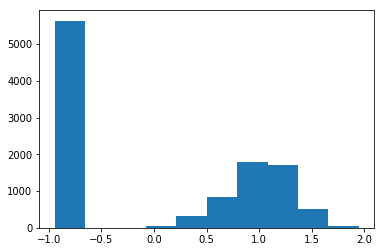

In [13]:
a = plt.hist(X_normal_train[:, 5])
plt.show()

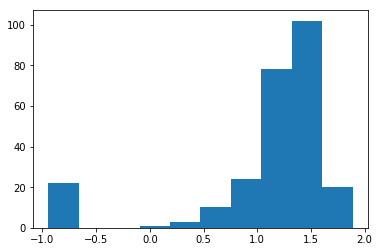

In [5]:
plt.hist(X_anomaly[:, 5])
plt.show()

In [6]:
from sklearn.neighbors import KernelDensity
clf = KernelDensity(bandwidth=1)
clf.fit(X_normal_train)

KernelDensity(algorithm='auto', atol=0, bandwidth=1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [7]:
clf.score_samples(X_normal_test).mean()

-7.757162032702103

In [8]:
clf.score_samples(X_anomaly).mean()

-9.889399064089876

In [9]:
pred = np.array(list(clf.score_samples(X_normal_test)) + list(clf.score_samples(X_anomaly)))
f1_score(y_test, pred < -8)

0.7509293680297398

In [10]:
thrs = np.arange(-5, -10, -0.01)
best_thrs = None
best_score = 0
for i in thrs:
    score = f1_score(y_test, pred < i)
    if score > best_score:
        best_score = score
        best_thrs = i
print (best_score, best_thrs)

0.7851373182552505 -7.3699999999999495


In [11]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=1)
clf.fit(X_normal_train)
pred = np.array(list(clf.score_samples(X_normal_test)) + list(clf.score_samples(X_anomaly)))

In [12]:
thrs = np.arange(min(pred), max(pred), 0.1)
best_thrs = None
best_score = 0
for i in thrs:
    score = f1_score(y_test, pred < i)
    if score > best_score:
        best_score = score
        best_thrs = i
print (best_score, best_thrs)

/Users/v.vikulin/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7892976588628764 -6.209928305196797


Как мы можем теперь новые знания применить в конкурсе?

Алгоритмы кластеризации позволяют решать огромное число задач. Давайте теперь попробуем поклассифицировать цифры!

In [37]:
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [38]:
digits = datasets.load_digits()
print ("Датасет размера: ", digits.data.shape)
data = digits.data
y = digits.target

Датасет размера:  (1797, 64)


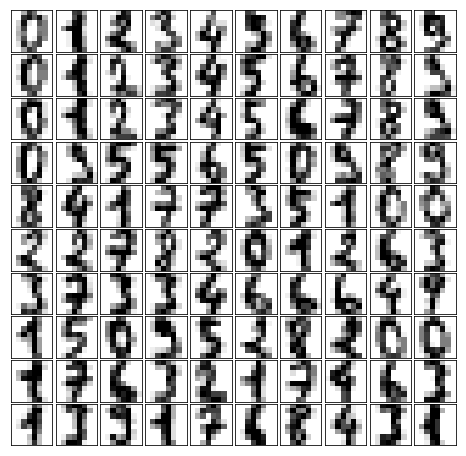

In [39]:
# code from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    plt.show()
        
plot_digits(digits.data)

In [40]:
def get_predicts_for_clusters(clusters,  labels):
    """
    Функция каждому кластеру присваивает метку, например, по принципу 
    большинства.
    clusters -- список размера N каждый элемент номер кластера из трейна
    labels   -- список размера N каждый элемент метка объекта  из трейна
    return   -- словарь {кластер : метка для данного кластера} 
    """
    cluster_predicts = {}
    for new_cluster in set(clusters):
        cluster_data = clusters[clusters == new_cluster]
        labels_data =  labels[clusters == new_cluster]
        best_label = None
        best_count = -1
        for new_label in set(labels):
            new_count = sum( labels_data == new_label )
            if new_count > best_count:
                best_count = new_count
                best_label = new_label
        cluster_predicts[new_cluster] = best_label
    return cluster_predicts


def get_predicts_on_test(clusters, cluster_2_pred):
    """
    Функция выдает предсказания по списку кластеров
    и выходу функции get_predicts_for_clusters
    clusters      -- список размера N каждый элемент номер кластера из теста
    cluster_pred  -- словарь {кластер : метка для данного кластера} 
    return        -- список размера N каждый элемент предсказанная метка из теста
    """
    return np.array([cluster_2_pred[i] if i in cluster_2_pred else 0 for i in clusters])

In [41]:
new_gmm = GaussianMixture(n_components=10, random_state=0).fit(data)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.9, random_state=241)


Задача, где неразмеченных данных больше, чем данных с таргетами. Semisupervised learning.

In [42]:
cluster_2_pred = get_predicts_for_clusters(new_gmm.predict(X_train), y_train)
preds_test = get_predicts_on_test(new_gmm.predict(X_test), cluster_2_pred) 
print ("Accuracy is " + str(accuracy_score(y_test, preds_test)))

Accuracy is 0.7972805933250927


In [46]:
new_gmm = GaussianMixture(n_components=10, random_state=0).fit(data)
for i in range(1, 30, 2):
    new_gmm = GaussianMixture(n_components=i, random_state=0).fit(data)
    cluster_2_pred = get_predicts_for_clusters(new_gmm.predict(X_train), y_train)
    preds_test = get_predicts_on_test(new_gmm.predict(X_test), cluster_2_pred) 
    print ("Num clusters: "  + str(i) +  ". Accuracy  is " + str(accuracy_score(y_test, preds_test)))



Num clusters: 1. Accuracy  is 0.09456118665018541
Num clusters: 3. Accuracy  is 0.15636588380716934
Num clusters: 5. Accuracy  is 0.35970333745364647
Num clusters: 7. Accuracy  is 0.5444993819530284
Num clusters: 9. Accuracy  is 0.6835599505562423
Num clusters: 11. Accuracy  is 0.8016069221260815
Num clusters: 13. Accuracy  is 0.811495673671199
Num clusters: 15. Accuracy  is 0.8887515451174289
Num clusters: 17. Accuracy  is 0.8671199011124846
Num clusters: 19. Accuracy  is 0.9177997527812114
Num clusters: 21. Accuracy  is 0.880716934487021
Num clusters: 23. Accuracy  is 0.8881334981458591
Num clusters: 25. Accuracy  is 0.9239802224969098
Num clusters: 27. Accuracy  is 0.907292954264524
Num clusters: 29. Accuracy  is 0.9134734239802225


Как Вы думаете, почему лучшее решение не для 10 компонент?

А что покажет логистическая регрессия?

In [44]:
scaler = StandardScaler().fit(data)
X_test_lr = scaler.transform(X_test)
X_train_lr = scaler.transform(X_train)
clf = LogisticRegression().fit(X_train_lr, y_train)
print (accuracy_score(y_test, clf.predict(X_test_lr)))

0.8899876390605687


А если извлечь признаки из EM?

In [45]:
new_gmm = GaussianMixture(n_components=20, random_state=0).fit(data)
X_train_em = new_gmm.predict_proba(X_train)
X_test_em = new_gmm.predict_proba(X_test)
scaler = StandardScaler().fit(X_test_em)
X_test_em = scaler.transform(X_test_em)
X_train_em = scaler.transform(X_train_em)
clf = LogisticRegression().fit(X_train_em, y_train)
print (accuracy_score(y_test, clf.predict(X_test_em)))

0.9276885043263288


Мораль: semisupervised learning реально помогает, позволяет извлекать структуру, обучаясь на всех данных, а не только на разметке!

In [50]:
data_new, components = new_gmm.sample(100)
data_new.shape

(100, 64)

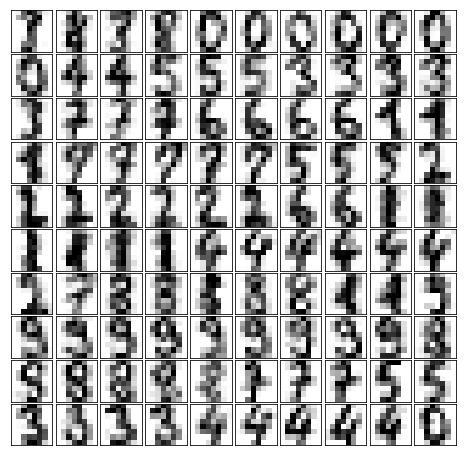

In [53]:
plot_digits(data_new)

Мы создали френкенштейна! АААА

Почему GMM такое может? Потому что генеративная модель, она моделирует  p(x, y), а только p(y|x)! Модель, которая моделирует p(y|x) называется дискриминативной. 

Какие Вы знаете дискриминативные модели? Генеративные?

https://medium.com/coinmonks/celebrity-face-generation-using-gans-tensorflow-implementation-eaa2001eef86 (смотреть только картинки, код и формулы пропускать!)